# ML for science - Unfold
## Baudoin von Sury - Pierre Vuillecard - Hugo Birch

## This notebook present the different predictions of CL using Neural Networks maching learning method.

We used the sklearn python librairy (https://keras.io) to perform different regression on our data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.activations import elu
from keras.constraints import maxnorm
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.utils.vis_utils import plot_model

from sklearn.preprocessing import MinMaxScaler

from scipy.stats import probplot

from neural_networks import *
from helpers import *

np.random.seed(123)

Using TensorFlow backend.


In [2]:
# Definition of the path of the data
path = os.getcwd()
path = path + '/ml_data/complete/complete/'

In [3]:
# Load the data (CL and kinematic alphas for the N_EXP experiments)
N_EXP = 4100
CL = load_data(path,N_EXP, cl = True)

# Shuffle the data
random_permuted_indices = np.random.permutation(N_EXP)
CL = CL[random_permuted_indices,:,:]

# Prediction of average CL from kinematic alpha
The aim of this part is to find the best neural network to predict CL from kinematic alphas. We used simple neural network structure from keras library and tunned it with the following techniques :
- Adding hidden layers.
- Playing with the hidden layers sizes.
- Trying different activation functions.
- Increasing the number of epoch.
- Choosing a wise early stopping criteria.
We analyse the performance of each different models through the mse and a probability plot.

In [4]:
def model_training(model,X_train,X_test,Y_train,Y_test, patience_ = 50 , plot=True ):
    """Train the different models and return the MSE values"""
    early_stop = EarlyStopping(monitor ="val_loss", patience = patience_ , verbose = 1)
    history = model.fit(X_train, Y_train, validation_split=0.2, epochs=2000 ,callbacks=[early_stop] , verbose=0)
    train_mse = model.evaluate(X_train, Y_train, verbose=0)
    test_mse = model.evaluate(X_test, Y_test, verbose=0)
    print('MSE Train: %.3f | MSE Test: %.3f' % (train_mse, test_mse))
    if plot :
        # plot loss during training
        plt.title('Loss / Mean Squared Error')
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.legend()
        plt.show()
    return train_mse,test_mse

## Base Line model
We first start by creating a base-line model in order to have a reference.

In [5]:
num_train = int(0.8*N_EXP)
# Split the data in train and test set
X_train = CL[:num_train,0,:]
X_test = CL[num_train:,0,:]
Y_train = CL[:num_train,1,:]
Y_test = CL[num_train:,1,:]

In [6]:
def build_model_base_line(summary = True):
    """Create the architecture of the base line model"""
    #architecture
    model = Sequential()
    model.add(Dense(200 ,input_shape=(200,)))
    if summary:
        print(model.summary())
    
    #optimiser 
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model

In [7]:
# Build and print the summary of the base-line model
model_base_line = build_model_base_line()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               40200     
Total params: 40,200
Trainable params: 40,200
Non-trainable params: 0
_________________________________________________________________
None


Epoch 00251: early stopping
MSE Train: 1.243 | MSE Test: 1.341


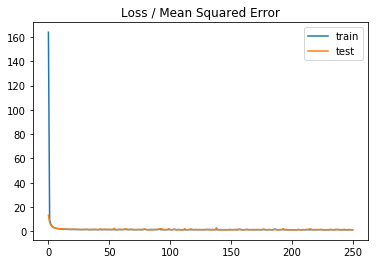

In [8]:
mse_train, mse_test = model_training(model_base_line,X_train,X_test,Y_train,Y_test, plot=True)

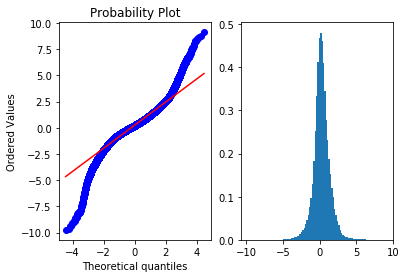

In [9]:
plot_stat(model_base_line,X_test,Y_test)

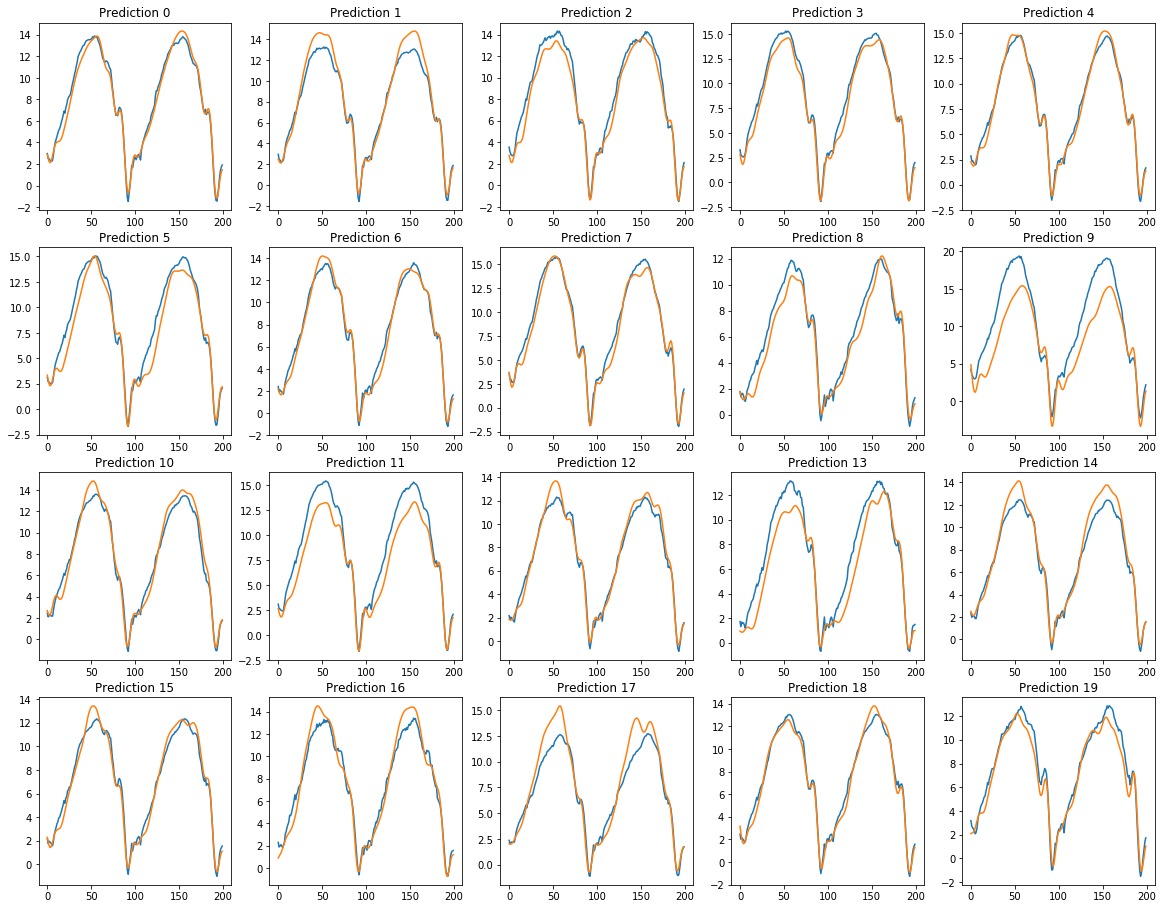

In [10]:
# Plots some examples of the predictions on the dataset
plot_prediction(model_base_line,X_test,Y_test)

###### Comments : The data seems to fit , but there is noise in the result and sometimes the error between data and prediction is huge. The QQplot seems great
#### We now are going to add activation function and one hidden layer

In [11]:
def build_model_1(summary = True):
    #architecture
    model = Sequential()
    model.add(Dense(200 ,input_shape=(200,)))
    model.add(Dense(200))
    if summary :
        print(model.summary())
    
    #optimiser 
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model

In [12]:
model_1 = build_model_1()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_3 (Dense)              (None, 200)               40200     
Total params: 80,400
Trainable params: 80,400
Non-trainable params: 0
_________________________________________________________________
None


Epoch 00439: early stopping
MSE Train: 1.009 | MSE Test: 1.080


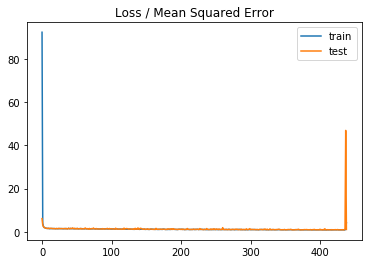

(1.0086535384015338, 1.0802633375656314)

In [13]:
model_training(model_1,X_train,X_test,Y_train,Y_test, plot=True)

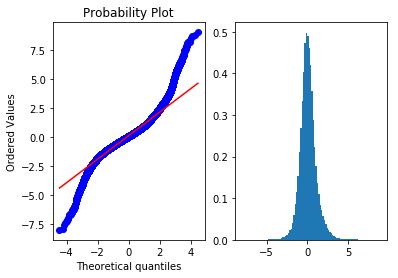

In [14]:
plot_stat(model_1,X_test,Y_test)

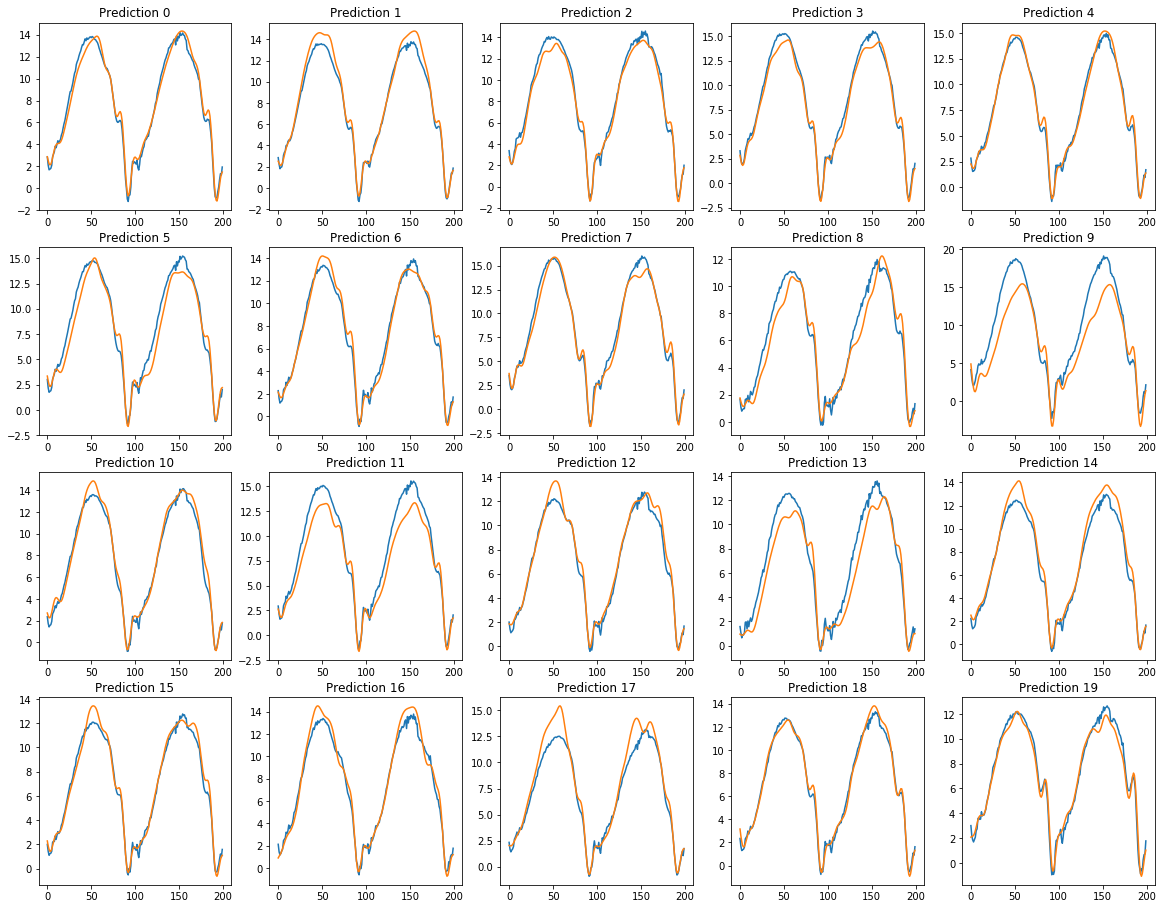

In [15]:
plot_prediction(model_1,X_test,Y_test)

###### Comments : We improved the MSE with this architecture but there is still some prediction which are not great
### We now add 2 hidden layers and use the elu activation function with an alpha = 2.5

In [16]:
def build_model_2(summary = True):
    
    #architecture
    model = Sequential()
    model.add(Dense(200 ,input_shape=(200,)))
    model.add(Activation(lambda x: elu(x, alpha=2)))
    model.add(Dense(200))
    model.add(Activation(lambda x: elu(x, alpha=2)))
    model.add(Dense(200))
    if summary :
        print(model.summary())
    
    #optimiser 
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model

In [17]:
model_2 = build_model_2()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 200)               40200     
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 200)               40200     
_________________________________________________________________
activation_2 (Activation)    (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 200)               40200     
Total params: 120,600
Trainable params: 120,600
Non-trainable params: 0
_________________________________________________________________
None


Epoch 00446: early stopping
MSE Train: 0.140 | MSE Test: 0.159


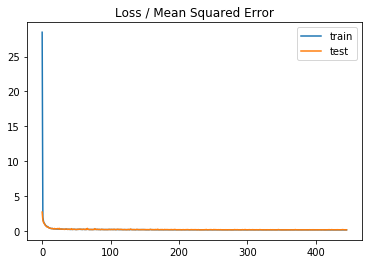

(0.14049811007046117, 0.1587591712794653)

In [18]:
model_training(model_2,X_train,X_test,Y_train,Y_test,plot=True )

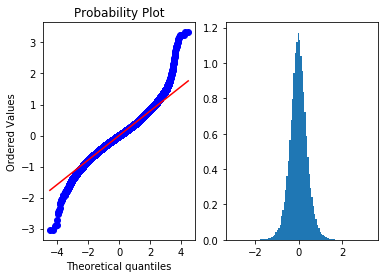

In [19]:
plot_stat(model_2,X_test,Y_test)

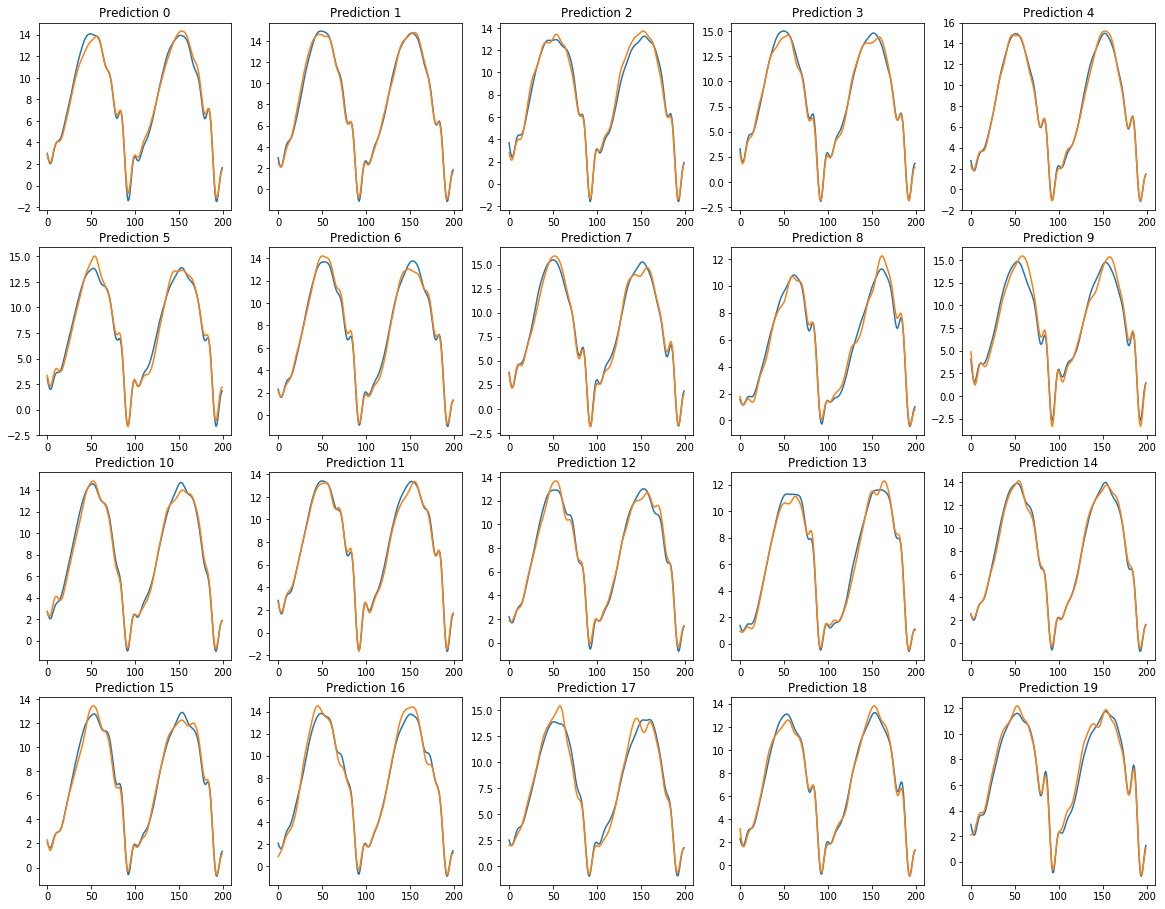

In [20]:
plot_prediction(model_2,X_test,Y_test)

###### Comments : MSE decreased a lot with this configuration
### We now try add hidden layers

In [21]:
def build_model_3(summary = True):
    
    #architecture
    model = Sequential()
    model.add(Dense(128 ,input_shape=(200,)))
    model.add(Activation(lambda x: elu(x, alpha=2)))
    model.add(Dense(64))
    model.add(Activation(lambda x: elu(x, alpha=2)))
    model.add(Dense(64))
    model.add(Activation(lambda x: elu(x, alpha=2)))
    model.add(Dense(200))
    if summary:
        print(model.summary())
    
    #optimiser 
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model

In [22]:
model_3 = build_model_3()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 128)               25728     
_________________________________________________________________
activation_3 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
activation_4 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
activation_5 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 200)              

Epoch 00300: early stopping
MSE Train: 0.148 | MSE Test: 0.167


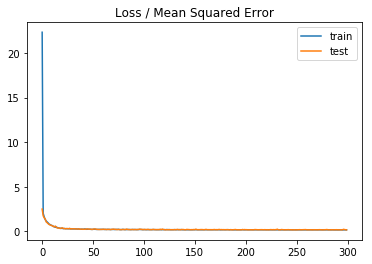

(0.14786188384381735, 0.16693973657561512)

In [23]:
model_training(model_3,X_train,X_test,Y_train,Y_test,plot= True)

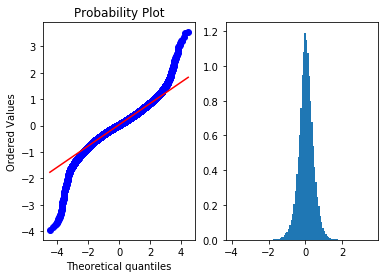

In [24]:
plot_stat(model_3,X_test,Y_test)

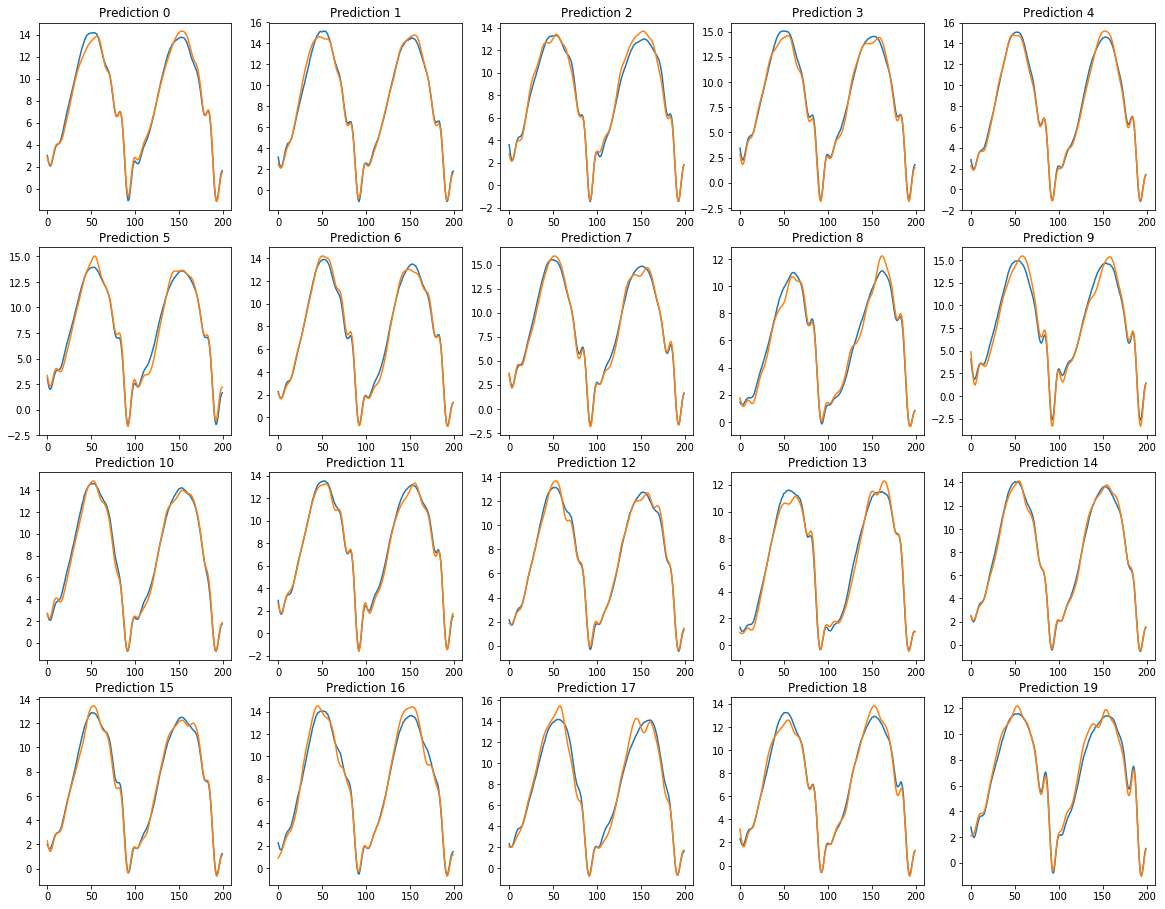

In [25]:
plot_prediction(model_3,X_test,Y_test)

###### Comments : The results is almost the same as the previous.
### We now try different value for alpha in the activation function elu

In [26]:
def build_model_4(summary = True):
    
    #architecture
    model = Sequential()
    model.add(Dense(128 ,input_shape=(200,)))
    model.add(Activation(lambda x: elu(x, alpha=1.5)))
    model.add(Dense(64))
    model.add(Activation(lambda x: elu(x, alpha=1.5)))
    model.add(Dense(64))
    model.add(Activation(lambda x: elu(x, alpha=1.5)))
    model.add(Dense(64))
    model.add(Activation(lambda x: elu(x, alpha=1.5)))
    model.add(Dense(128))
    model.add(Activation(lambda x: elu(x, alpha=1.5)))
    model.add(Dense(200, activation = 'linear'))
    if summary :
        print(model.summary())
    
    #optimiser 
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model

In [27]:
model_4 = build_model_4()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 128)               25728     
_________________________________________________________________
activation_6 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
activation_7 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
activation_8 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)               

Epoch 00234: early stopping
MSE Train: 0.166 | MSE Test: 0.185


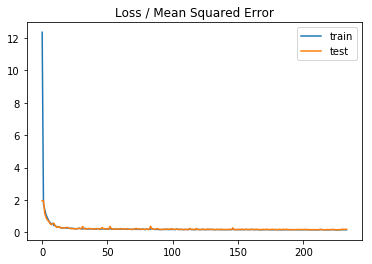

(0.1656758197923986, 0.18536782192020881)

In [28]:
model_training(model_4,X_train,X_test,Y_train,Y_test,plot=True )

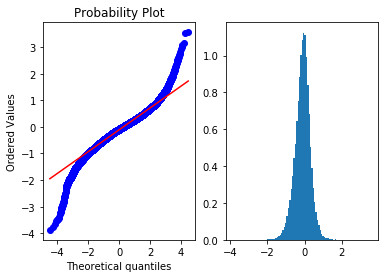

In [29]:
plot_stat(model_4,X_test,Y_test)

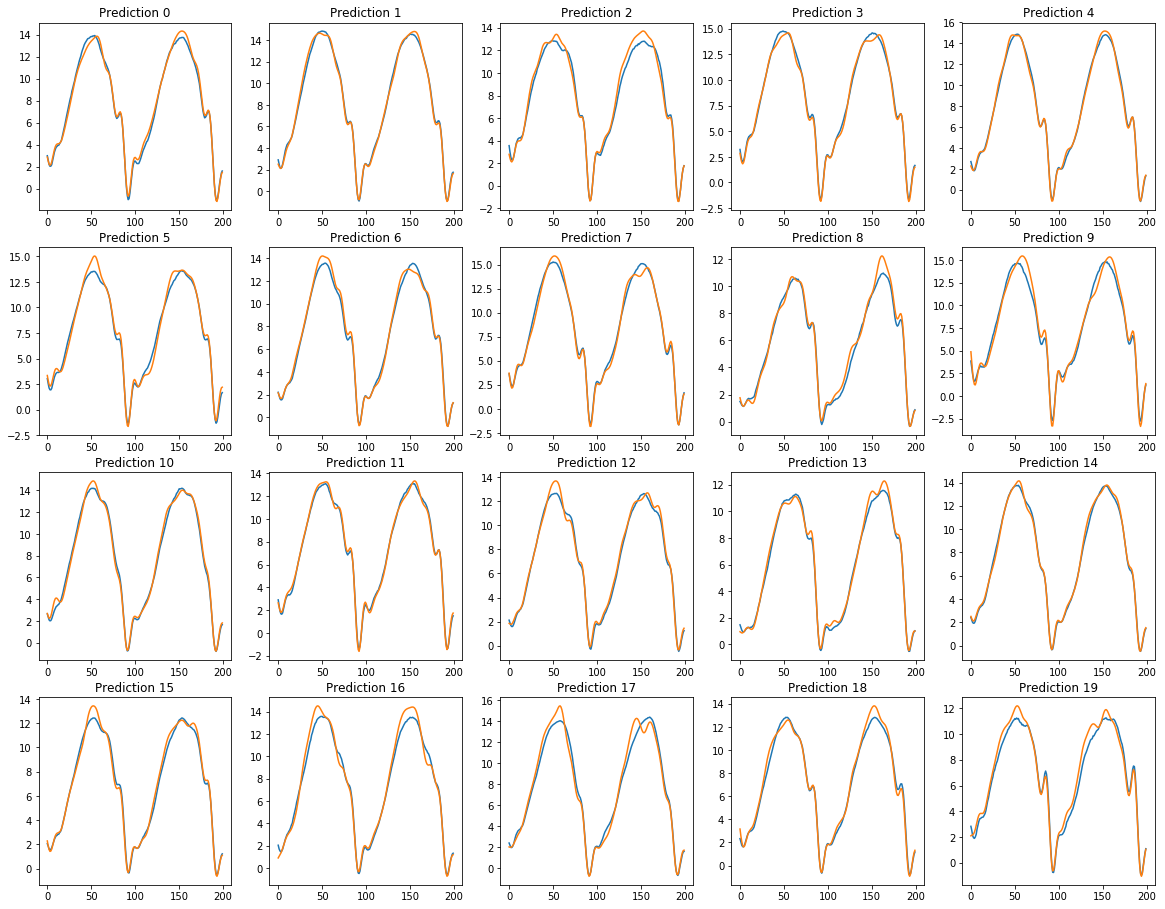

In [30]:
plot_prediction(model_4,X_test,Y_test)

###### Comments : The MSE increase, so this configuration is less great than the previous one
### We now now use multiple hidden layers with elu activation function

In [31]:
def build_model_5(summary = True):
    
    #architecture
    model = Sequential()
    model.add(Dense(128 ,input_shape=(200,) , activation = 'elu'))
    model.add(Dense(64 , activation = 'elu'))
    model.add(Dense(64 , activation = 'elu'))
    model.add(Dense(64 , activation = 'elu'))
    model.add(Dense(128, activation = 'elu'))
    model.add(Dense(200, activation = 'linear'))
    if summary :
        print(model.summary())
    
    #optimiser 
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model

In [32]:
model_5 = build_model_5()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 128)               25728     
_________________________________________________________________
dense_18 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_20 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_21 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_22 (Dense)             (None, 200)               25800     
Total params: 76,424
Trainable params: 76,424
Non-trainable params: 0
__________________________________________________

Epoch 00190: early stopping
MSE Train: 0.146 | MSE Test: 0.164


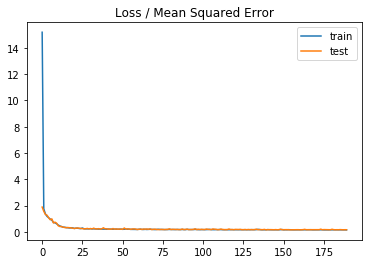

(0.14556918086075202, 0.1636219948530197)

In [33]:
model_training(model_5,X_train,X_test,Y_train,Y_test)

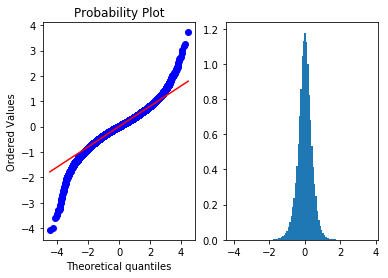

In [34]:
plot_stat(model_5,X_test,Y_test)

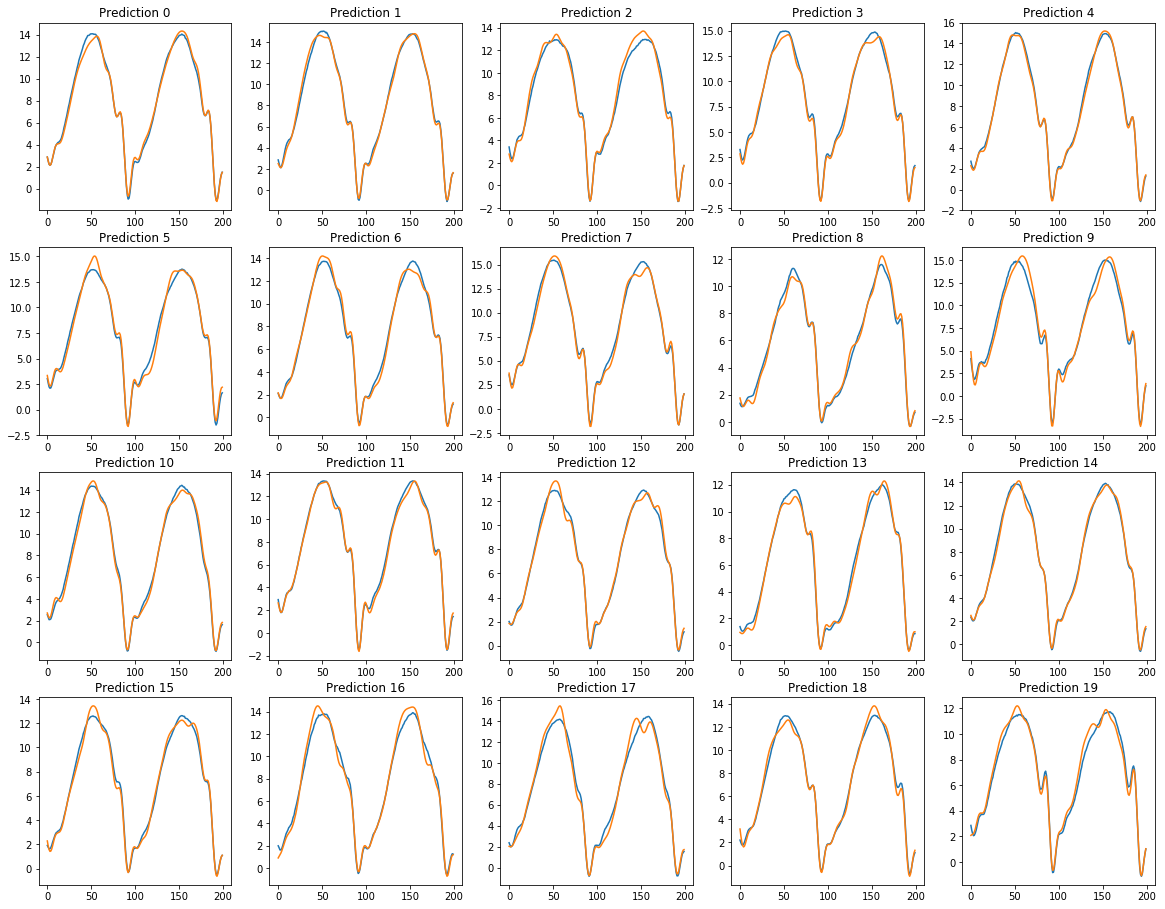

In [35]:
plot_prediction(model_5,X_test,Y_test)

###### Comments :  This configuration is great and has a great MSE
### We now add 2 hidden layers and use the elu activation function with an alpha = 2.5

In [36]:
def build_model_6(summary = True):
    
    #architecture
    model = Sequential()
    model.add(Dense(128 ,input_shape=(200,) , activation = 'elu'))
    model.add(Dense(64 , activation = 'elu'))
    model.add(Dense(64 , activation = 'elu'))
    model.add(Dense(64 , activation = 'elu'))
    model.add(Dense(128, activation = 'elu'))
    model.add(Dense(200, activation = 'linear'))
    if summary:
        print(model.summary())
    
    #optimiser 
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model

In [37]:
model_6 = build_model_6()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 128)               25728     
_________________________________________________________________
dense_24 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_25 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_26 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_27 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_28 (Dense)             (None, 200)               25800     
Total params: 76,424
Trainable params: 76,424
Non-trainable params: 0
__________________________________________________

Epoch 00311: early stopping
MSE Train: 0.159 | MSE Test: 0.182


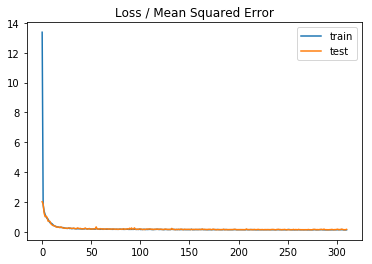

(0.15887155605525505, 0.18181434215568915)

In [41]:
model_training(model_6,X_train,X_test,Y_train,Y_test)

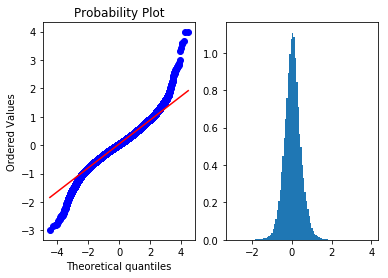

In [42]:
plot_stat(model_6,X_test,Y_test)

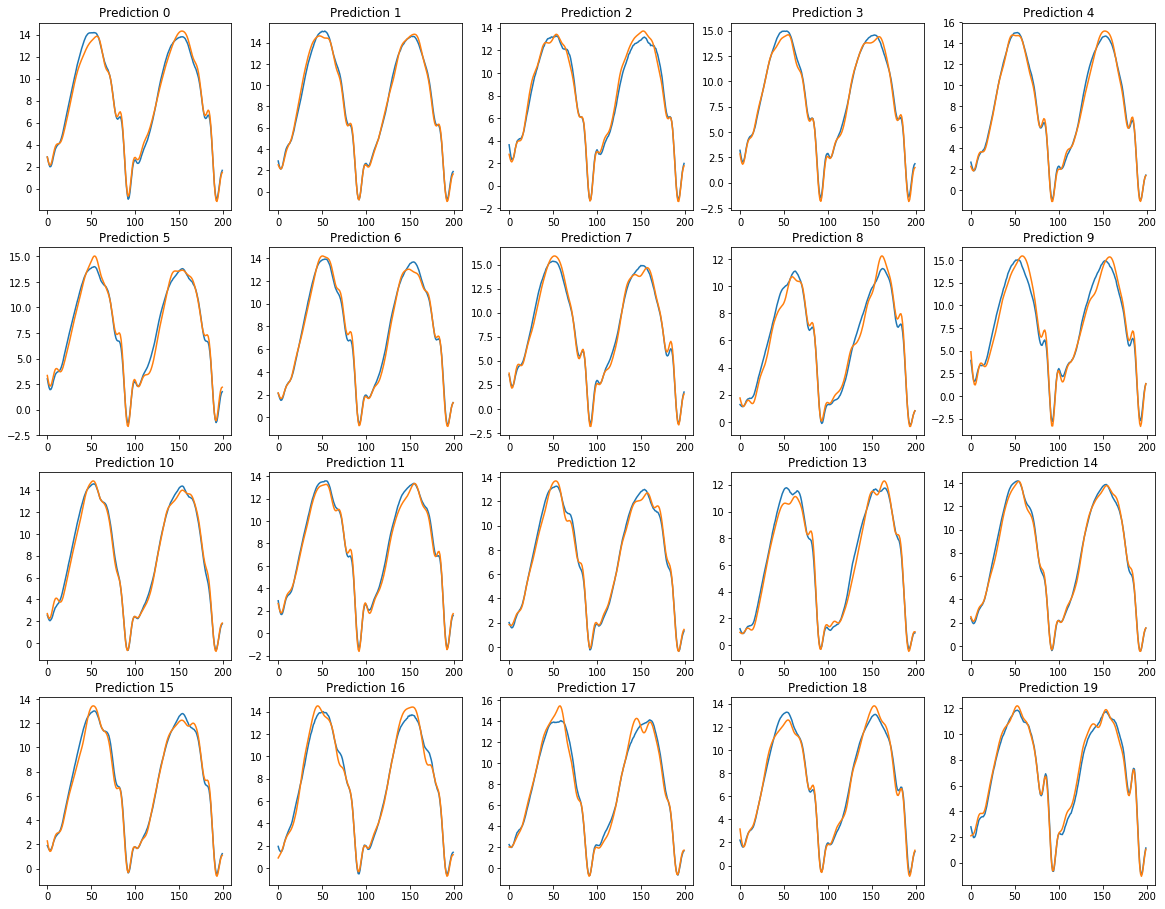

In [43]:
plot_prediction(model_6,X_test,Y_test)

###### Comments : We can see that this new configuration is not great because the MSE increase.

## We are now going to do cross validation for the base line model and the best model (2).

In [48]:
k_fold = 4
train_mse_1,test_mse_1 = cross_validation(build_model_base_line, CL,k_fold)
print(f"Cross validation results : MSE train = {train_mse_1} | MSE test = {test_mse_1}")

Epoch 00709: early stopping
MSE Train: 14.766 | MSE Test: 14.123
Epoch 00519: early stopping
MSE Train: 17.499 | MSE Test: 15.750
Epoch 00699: early stopping
MSE Train: 13.474 | MSE Test: 15.744
Epoch 00788: early stopping
MSE Train: 14.934 | MSE Test: 14.996
MSE train = 15.16829808611211 | MSE test = 15.153300503812186


In [174]:
k_fold = 4
train_mse,test_mse = cross_validation(build_model_5, CL,k_fold)
print(f"Cross validation results : MSE train = {train_mse} | MSE test = {test_mse}")

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 200)               40200     
_________________________________________________________________
activation_19 (Activation)   (None, 200)               0         
_________________________________________________________________
dense_82 (Dense)             (None, 200)               40200     
_________________________________________________________________
activation_20 (Activation)   (None, 200)               0         
_________________________________________________________________
dense_83 (Dense)             (None, 200)               40200     
Total params: 120,600
Trainable params: 120,600
Non-trainable params: 0
_________________________________________________________________
None
Epoch 00371: early stopping
Model: "sequential_33"
_________________________________________________________

## Now we are going to try to rescale the input in [0,1]

In [44]:
# Scaling the data
def scale( X,min_ , max_ ):
    return (X - min_)/(max_-min_) 

min_ = -90
max_ = 90 
num_train    = int(0.8*N_EXP)
X_train_insc = scale(CL[:num_train,0,:],min_ , max_ )
X_test_insc  = scale(CL[num_train:,0, :],min_ , max_ )
Y_train_insc = CL[:num_train,1,:]
Y_test_insc  = CL[num_train:,1,:]

## Base Line model
We first start by creating a base-line model in order to have a reference.

In [50]:
def build_model_baseline(summary = True):
    model = Sequential()
    model.add(Dense(200 ,input_shape=(200,) ))
    if summary :
        print(model.summary())
    
    #optimiser 
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model

In [51]:
model_rs_bs = build_model_baseline()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 200)               40200     
Total params: 40,200
Trainable params: 40,200
Non-trainable params: 0
_________________________________________________________________
None


Epoch 01428: early stopping
MSE Train: 0.344 | MSE Test: 0.355


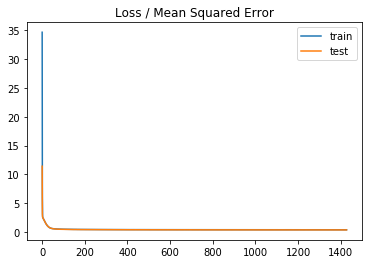

(0.3439519537658226, 0.3551569599930833)

In [52]:
model_training(model_rs_bs,X_train_insc , X_test_insc , Y_train_insc , Y_test_insc , 50,plot = True)

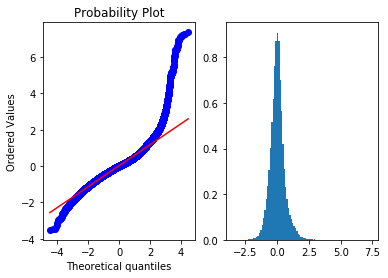

In [53]:
plot_stat(model_rs_bs,X_test_insc,Y_test_insc)

###### Comments : The MSE is already way better compare to the baseline without input.

## Then let's apply the rescale to Model 1

In [54]:
def build_model_rs_1(summary = True):
    
    #architecture
    model = Sequential()
    model.add(Dense(150 ,input_shape=(200,) , activation = 'tanh' ))
    model.add(Dense(100 , activation = 'tanh'))
    model.add(Dense(150 , activation = 'tanh'))
    model.add(Dense(200))
    if summary :
        print(model.summary())
    
    #optimiser 
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model

In [55]:
model_rs_1 = build_model_rs_1()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 150)               30150     
_________________________________________________________________
dense_31 (Dense)             (None, 100)               15100     
_________________________________________________________________
dense_32 (Dense)             (None, 150)               15150     
_________________________________________________________________
dense_33 (Dense)             (None, 200)               30200     
Total params: 90,600
Trainable params: 90,600
Non-trainable params: 0
_________________________________________________________________
None


Epoch 00258: early stopping
MSE Train: 0.147 | MSE Test: 0.175


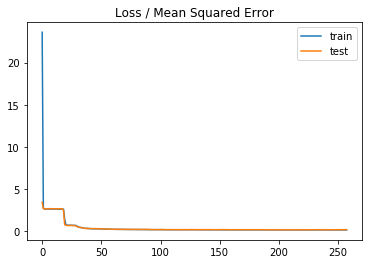

(0.1472888727013658, 0.17519622903044632)

In [56]:
model_training(model_rs_1,X_train_insc , X_test_insc , Y_train_insc , Y_test_insc , 50,plot = True)

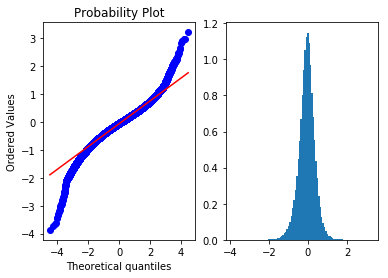

In [57]:
plot_stat(model_rs_1,X_test_insc,Y_test_insc)

###### Comments : Again the MSE is halved and the QQplot is more than acceptable

## Then let's apply the rescale to Model 2

In [58]:
def build_model_rs_2():
    
    #architecture
    model = Sequential()
    model.add(Dense(128,input_shape=(200,) , activation = 'sigmoid' ))
    model.add(Dense(64 , activation = 'sigmoid'))
    model.add(Dense(200 ))
    print(model.summary())
    
    #optimiser 
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model

In [59]:
model_rs_2 = build_model_rs_2()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 128)               25728     
_________________________________________________________________
dense_35 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_36 (Dense)             (None, 200)               13000     
Total params: 46,984
Trainable params: 46,984
Non-trainable params: 0
_________________________________________________________________
None


Epoch 00833: early stopping
MSE Train: 0.138 | MSE Test: 0.155


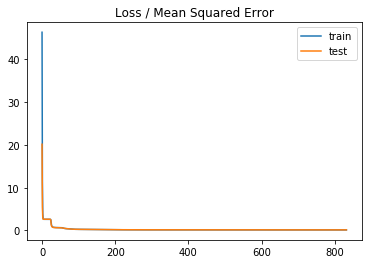

(0.13847081755719534, 0.1550330805342372)

In [60]:
model_training(model_rs_2,X_train_insc , X_test_insc , Y_train_insc , Y_test_insc , 50,plot = True)

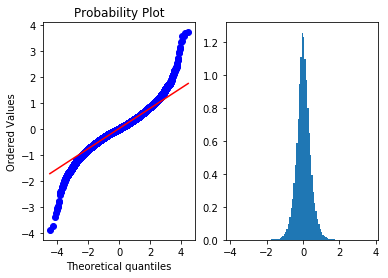

In [61]:
plot_stat(model_rs_2,X_test_insc,Y_test_insc)

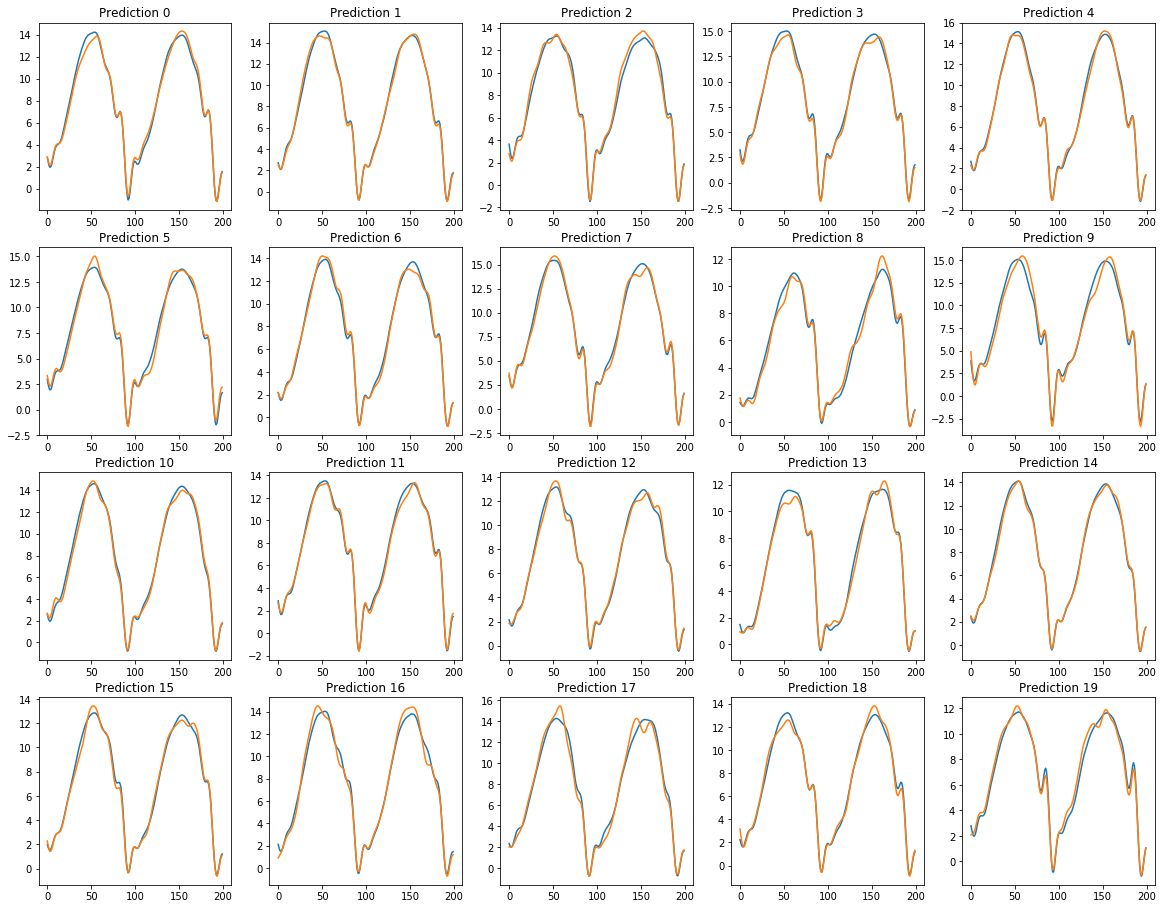

In [62]:
plot_prediction(model_rs_2 , X_test_insc , Y_test_insc)

###### Comments : Again the MSE decrease ! 

## Then let's apply the rescale to Model 3

In [68]:
def build_model_rs_3(summary = True):
    
    #architecture
    model = Sequential()
    model.add(Dense(128,input_shape=(200,) , activation = 'sigmoid' ))
    model.add(Dense(200 ))
    if summary :
        print(model.summary())
    
    
    #optimiser 
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model

In [64]:
model_rs_3 = build_model_rs_3()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 128)               25728     
_________________________________________________________________
dense_38 (Dense)             (None, 200)               25800     
Total params: 51,528
Trainable params: 51,528
Non-trainable params: 0
_________________________________________________________________
None


Epoch 00789: early stopping
MSE Train: 0.140 | MSE Test: 0.153


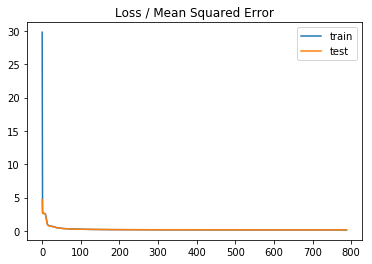

(0.139501623118796, 0.15288147591963047)

In [65]:
model_training(model_rs_3,X_train_insc , X_test_insc , Y_train_insc , Y_test_insc , 50,plot = True)

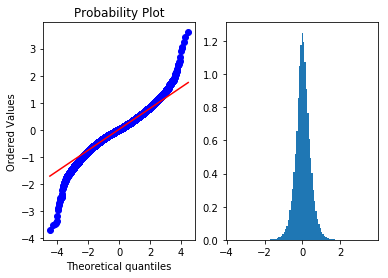

In [66]:
plot_stat(model_rs_3,X_test_insc,Y_test_insc)

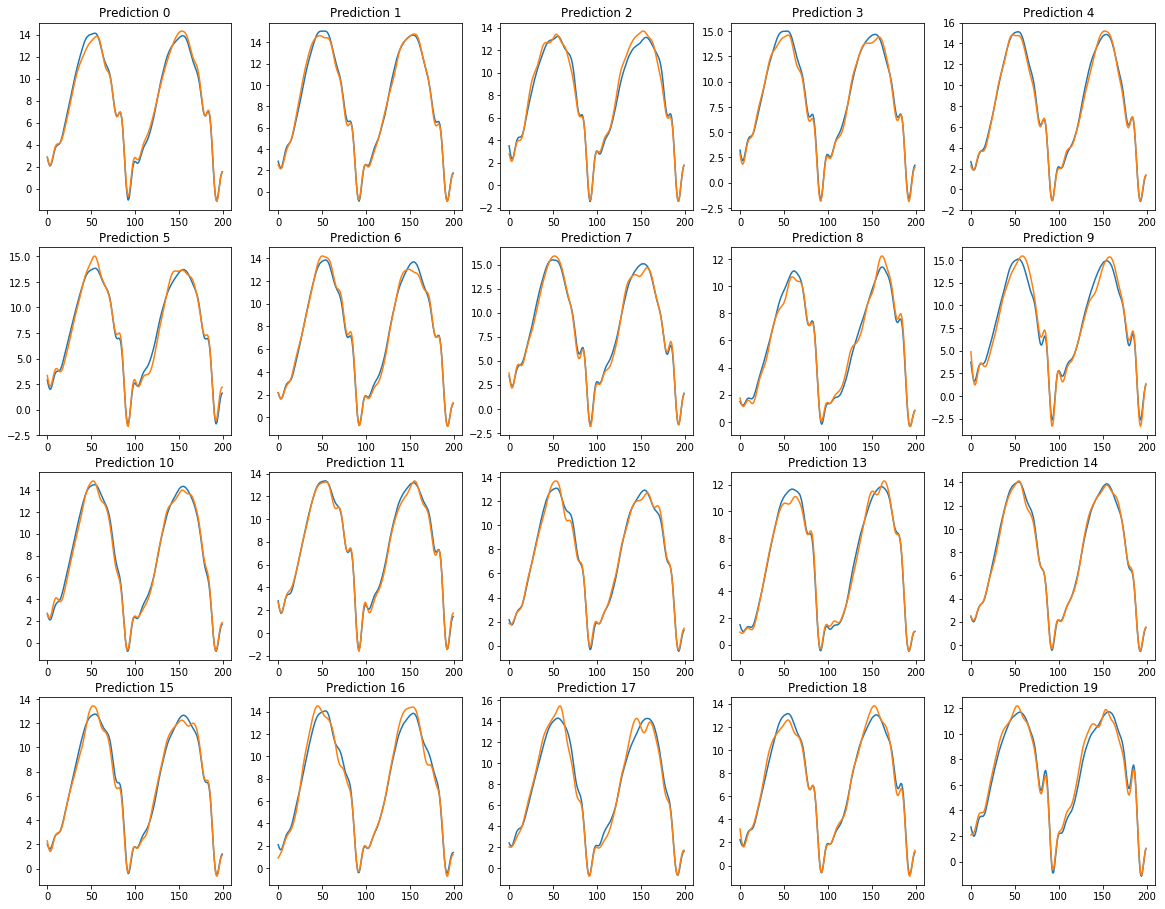

In [67]:
plot_prediction(model_rs_3 , X_test_insc , Y_test_insc)

### Cross validation on the base line model and the best model (3)

Epoch 01110: early stopping
MSE Train: 0.360 | MSE Test: 0.331


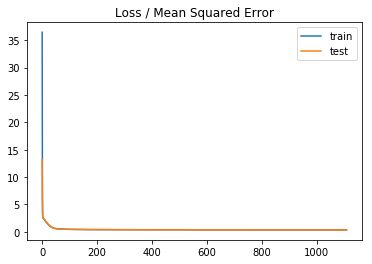

Epoch 01201: early stopping
MSE Train: 0.350 | MSE Test: 0.370


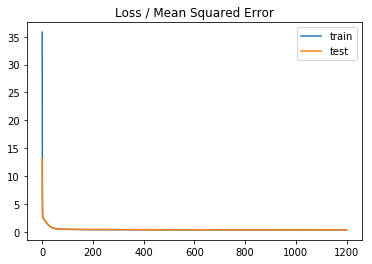

Epoch 01141: early stopping
MSE Train: 0.346 | MSE Test: 0.379


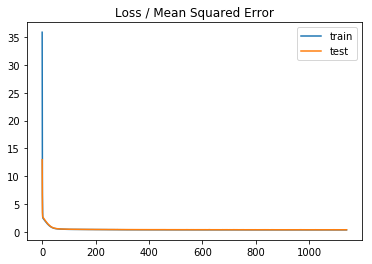

Epoch 01376: early stopping
MSE Train: 0.351 | MSE Test: 0.346


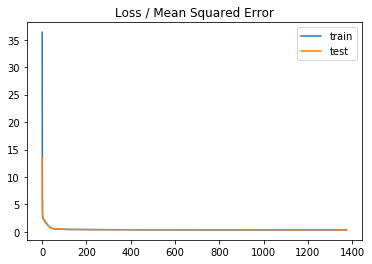

Cross validation results : MSE train = 0.3518964560342029 | MSE test = 0.3563588330458577


In [70]:
k_fold = 4
patience_= 50
train_mse,test_mse = cross_validation_rs(build_model_baseline,CL,k_fold,50)
print(f"Cross validation results : MSE train = {train_mse} | MSE test = {test_mse}")

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_83 (Dense)             (None, 350)               70350     
_________________________________________________________________
dense_84 (Dense)             (None, 200)               70200     
Total params: 140,550
Trainable params: 140,550
Non-trainable params: 0
_________________________________________________________________
None
Epoch 00827: early stopping
Train: 0.701, Test: 0.702


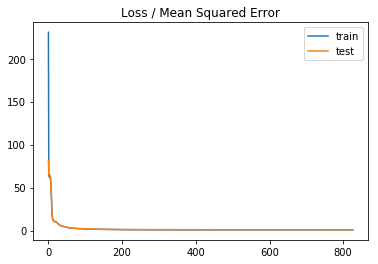

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 350)               70350     
_________________________________________________________________
dense_86 (Dense)             (None, 200)               70200     
Total params: 140,550
Trainable params: 140,550
Non-trainable params: 0
_________________________________________________________________
None
Epoch 00931: early stopping
Train: 0.690, Test: 0.743


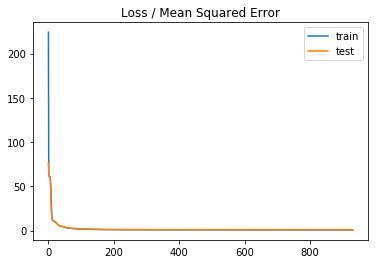

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_87 (Dense)             (None, 350)               70350     
_________________________________________________________________
dense_88 (Dense)             (None, 200)               70200     
Total params: 140,550
Trainable params: 140,550
Non-trainable params: 0
_________________________________________________________________
None
Epoch 00708: early stopping
Train: 0.703, Test: 0.785


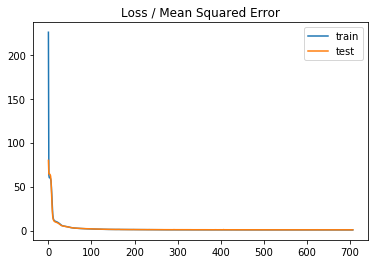

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_89 (Dense)             (None, 350)               70350     
_________________________________________________________________
dense_90 (Dense)             (None, 200)               70200     
Total params: 140,550
Trainable params: 140,550
Non-trainable params: 0
_________________________________________________________________
None
Epoch 00679: early stopping
Train: 0.701, Test: 0.795


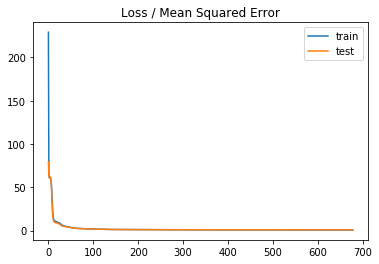

In [91]:
k_fold = 4
patience_=50
train_mse_1 , test_mse_1 = cross_validation_rs(build_model_rs_3,CP,k_fold,50)
print(f"Cross validation results : MSE train = {train_mse_1} | MSE test = {test_mse_1}")

## we obtain a better result by rescaling the input !

# Conclusion :
### Best model = build_model_rs_3 with a MSE = 0.153